<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/EN/S06_Time-Series_Analytics/S06_Simple_TS_using_darts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S06 Simple time-series forecast and evaluation using darts

### Introduction

Time series demand forecasting is crucial for effective supply chain management. With accurate demand forecasts, businesses can optimize inventory, improve demand planning, enhance sales forecasting, and mitigate supply chain risks.

With recent development in Python and opensources, there are many simple-to-use packages such as [statsmodels](https://www.statsmodels.org/stable/index.html) (mainly for statistical techniques), [Prophet (by Facebook)](https://facebook.github.io/prophet/), [GluonTS (by Amazon)] (https://ts.gluon.ai/stable/), and many other libraries. Most libraries require a specific (but similar) data input format and processes. Thus, the most important step to use such packages is to prepare the data in the right format.

There are also opensource libaries that are built upon many time-series forecasting packages and provide interfaces to many time-series algorithms such as [sktime](https://www.sktime.net/en/latest/index.html) and [darts](https://unit8co.github.io/darts/). These time-series forecasting interfaces greatly simplify forecasting with its intuitive API and diverse range of models, including classical statistical methods and modern machine learning approaches including deep-learning-based models.

In this notebook, we will provide a simple walkthrough to the time-series analysis using darts. There is also a demo that provides more comprehensive pipelines of the forecasting processes.

First of all, an installation of `dart` is mandatory since it is not included in Colab by default.

In [ ]:
!pip install darts

### **Step 1**: Load data

In order to use `darts`, it requires a specific object called `TimeSeries`. This is basically very similar to `DataFrame` in the time-series format and we can simply pass the time-series in the Series or DataFrame format to create the `TimeSeries` object for `darts`. **IMPORTANT**: The index of the Series or DataFrame prior to conversion must be in `datetime` format (i.e., using the function `pd.to_datetime(...)`)

In [2]:
# simple Python code for time-series using darts

import pandas as pd
import darts

data = pd.read_csv('https://bit.ly/m5simple', index_col='ds')
data.index = pd.to_datetime(data.index)

y_timeseries = darts.TimeSeries.from_series(data['y'])

### **Step 2**: Train/test split

We then split the time-series data into the training set and test set. The test set contains the last 52 data points whereas the training set contains all the data from the beginning until the period preceeding the test set.

In [3]:
test_n_points = 52

start = len(data)-test_n_points
train, test = y_timeseries.split_before(start)

### **Step 3**: Train the model

Similar to `sklearn`, we can simply create a model object and fit the data to the model. In the following block, we provide examples of different time-series models and you can choose one to try. Then the function `.fit(...)` is used to fit the data to the model (training).

The list of the models supported by `darts` is available here:
https://unit8co.github.io/darts/generated_api/darts.models.forecasting.html

In [4]:
from darts.models import ExponentialSmoothing, AutoARIMA, Theta, Prophet, Croston, NBEATSModel

model = ExponentialSmoothing()
# model = AutoARIMA()
# model = Theta()
# model = Prophet()
# model = Croston()
# model = NBEATSModel(input_chunk_length=52, output_chunk_length=52, n_epochs=50)

model.fit(train)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=None, random_state=0, kwargs=None)

### **Step 4**: Create predictions for the period of the test set.

We can then generate the prediction of the following 52 periods, which corresponds to the period in the test set in order to measure the quality of the forecasts on an out-of-sample basis (using test data that has not been included in the training set). We can also convert the output into series (by using `.pd_series()`) or dataframe (by using `.pd_dataframe()`).

In [5]:
forecast = model.predict(len(test))

forecast.pd_series()

,y
ds,
2015-05-31,4181.942086
2015-06-07,4277.531954
2015-06-14,3937.006498
2015-06-21,4111.489256
2015-06-28,4039.845800
2015-07-05,4237.092872
2015-07-12,3902.429786
2015-07-19,4165.645873
2015-07-26,3739.859053


### **Step 5**: Measure the forecasting errors.

We measure the results using five different error measures, i.e., Mean Absolute Percentage Error (MAPE) using the function `mape()`, Symmetric Mean Absolute Percentage Error (sMAPE)using the function `smape()`, Root Mean Squared Scaled Error (RMSSE) using the function `rmsse()`, Root Mean Squared Error (RMSE) using the function `rmse()`, and Mean Error (ME) using the function `merr()`.

In [6]:
m_mape = darts.metrics.mape(test, forecast)
m_smape = darts.metrics.smape(test, forecast)
m_rmsse = darts.metrics.rmsse(test, forecast, insample = train)
m_rmse = darts.metrics.rmse(test, forecast)
m_merr = darts.metrics.merr(test, forecast)


print(f"The model obtains Mean Absolute Percentage Error: {m_mape:.2f}%")
print(f"The model obtains Symmetric Mean Absolute Percentage Error: {m_smape:.2f}%")
print(f"The model obtains Root Mean Squared Scaled Error: {m_rmsse:.2f}")
print(f"The model obtains Root Mean Squared Error: {m_rmse:.2f}")
print(f"The model obtains Mean Error: {m_merr:.2f}")

The model obtains Mean Absolute Percentage Error: 13.55%
The model obtains Symmetric Mean Absolute Percentage Error: 12.45%
The model obtains Root Mean Squared Scaled Error: 1.27
The model obtains Root Mean Squared Error: 576.45
The model obtains Mean Error: -478.49


You can also plot the results using `seaborn`

<Axes: xlabel='ds', ylabel='y'>

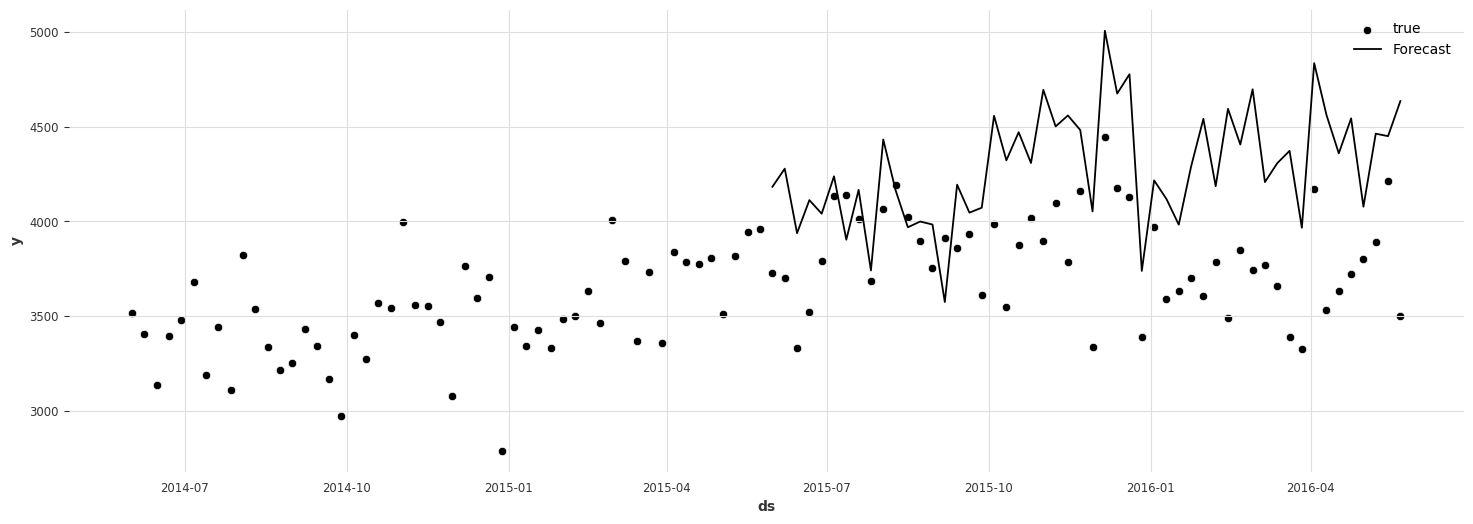

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18,6))

sns.scatterplot(x = data[-104:].index, y = data['y'][-104:].values, label = 'true')
sns.lineplot(data = forecast.pd_series(), label = 'Forecast')